# Spectral maps

spotter can be used to model time series spectra of non-uniform stars. In this tutorial we showcase some of these features.

```{important}
The features shown in this tutotrial are still experimental and not tested against ground truth. Use with care!
```

## A simple spotted surface

We first create a surface with a single circular spot

/Users/lgarcia/code/spotter/spotter/star.py:48: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return cls(y, **kwargs)
/Users/lgarcia/code/spotter/spotter/star.py:82: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return self.__class__(y, self.u, self.inc, self.period)


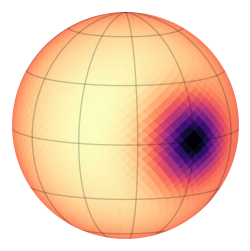

In [1]:
from spotter import Star
from spotter import core, show
import matplotlib.pyplot as plt

star = Star.from_sides(2**4, period=0.02, u=(0.2, 0.2), inc=1.4)
spot = core.soft_spot(star.sides, 0.0, 0.0, 0.15)

plt.figure(figsize=(3, 3))
show(star - spot, 0.63)

Here we will assume a stellar spectrum made of a single line with a Gaussian profile

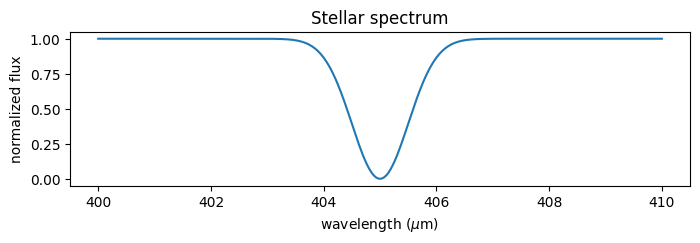

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp


def gaussian(x, mu, sigma):
    return jnp.exp(-((x - mu) ** 2) / (2 * sigma**2))


wv = jnp.linspace(400, 410, 500) * 1e-9
star_spectrum = 1 - gaussian(wv, wv.mean(), 0.5e-9)

plt.figure(figsize=(8, 2))
plt.plot(wv * 1e9, star_spectrum)
plt.xlabel("wavelength ($\mu$m)")
plt.title("Stellar spectrum")
_ = plt.ylabel("normalized flux")

and we will assume that the star and its spot share the same spectrum. With spotter, we are in charge of setting the spectra of each individual pixel. Let's do that

In [3]:
spectra = jnp.zeros((star.size, len(wv)))
spectra += star_spectrum[None, :] * (star - spot).y[:, None]

/Users/lgarcia/code/spotter/spotter/star.py:82: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return self.__class__(y, self.u, self.inc, self.period)


This result in a spectral spatial map of shape *(pixels, wavelength)*

In [4]:
spectra.shape

(3072, 500)

From there we can compute the observed intensity of the star at a given phase 

In [5]:
from spotter.doppler import spectrum

observed_spectrum = spectrum(star, wv, star_spectrum, 0.0)

Let's plot the observed spectrum at different phases

/Users/lgarcia/code/spotter/spotter/star.py:82: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return self.__class__(y, self.u, self.inc, self.period)


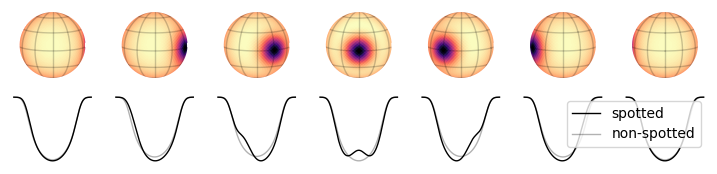

In [6]:
from spotter.doppler import spectrum

n = 7
fig, axes = plt.subplots(2, n, figsize=(9, 2 * n / n))
nonspotted_spectrum = spectrum(star, wv, star_spectrum, jnp.pi)

for i, phase in enumerate(jnp.linspace(jnp.pi / 2, -jnp.pi / 2, n)):
    ax = axes[1, i]
    ax.plot(spectrum(star, wv, spectra, phase), c="k", lw=1, label="spotted")
    ax.plot(nonspotted_spectrum, "-", alpha=0.3, c="k", lw=1, label="non-spotted")
    ax.axis("off")

    ax = axes[0, i]
    show(star - spot, phase, ax=ax)

    if i == n - 1:
        plt.legend()

## Spectral spatial maps

Because of their cooler temperatures (among other factors), starspots should have their own spectrum, different from the star's. Hence, in this section, we define the spectra of the star and the spot separately

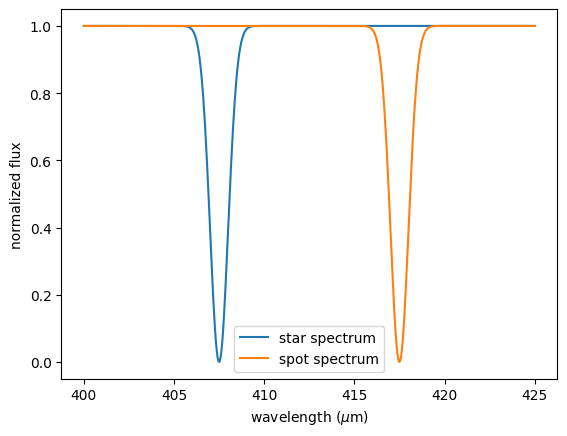

In [7]:
wv = jnp.linspace(400, 425, 500) * 1e-9
star_spectrum = 1 - gaussian(wv, wv.mean() - 0.2 * jnp.ptp(wv), 0.5e-9)
spot_spectrum = 1 - gaussian(wv, wv.mean() + 0.2 * jnp.ptp(wv), 0.5e-9)

plt.plot(wv * 1e9, star_spectrum, label="star spectrum")
plt.plot(wv * 1e9, spot_spectrum, label="spot spectrum")
plt.legend()
plt.xlabel("wavelength ($\mu$m)")
_ = plt.ylabel("normalized flux")

The next step consists in setting the spectra of each pixel in the map

In [8]:
import numpy as np

spectra = np.zeros((star.size, len(wv)))

# spectrum of the star
spectra = (star.y - spot)[:, None] * star_spectrum[None, :]
# spectrum of the spot
spectra = spectra + spot[:, None] * spot_spectrum[None, :]

As in the previous example, here is the observed spectrum at different phases

/Users/lgarcia/code/spotter/spotter/star.py:82: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return self.__class__(y, self.u, self.inc, self.period)


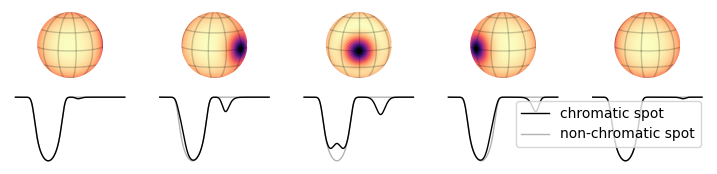

In [9]:
n = 5
fig, axes = plt.subplots(2, n, figsize=(9, 2 * n / n))

for i, phase in enumerate(jnp.linspace(jnp.pi / 1.8, -jnp.pi / 1.8, n)):
    ax = axes[1, i]
    ax.plot(spectrum(star, wv, spectra, phase), c="k", lw=1, label="chromatic spot")
    ax.plot(
        spectrum(star, wv, star_spectrum, phase),
        c="k",
        lw=1,
        alpha=0.3,
        label="non-chromatic spot",
    )
    ax.axis("off")

    ax = axes[0, i]
    show(star - spot, phase, ax=ax)

    if i == n - 1:
        plt.legend()